# Setup

In [17]:
import scrnatools as rna
import string
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import anndata as ad
import random
import os
import shutil

In [48]:
sc.set_figure_params(figsize=(4,4), dpi=150, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
rna.configs.verbosity = "info"

## Data paths

### demeter

In [3]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [4]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

# Import data

In [14]:
epitheliumData = sc.read(f"{processedDataPath}M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
epitheliumData.X = epitheliumData.layers["counts"]

In [50]:
stromalData = sc.read_10x_h5(f"{rawDataPath}Thymus/Corey_thymus/cellranger_alignment/CS/filtered_feature_bc_matrix.h5")
stromalData.var_names_make_unique()
stromalData.obs["cell_type"] = "stromal_unassigned"
stromalData.obs["batch"] = "CS"
stromalData.obs["genotype"] = "WT"
stromalData.obs["experiment"] = "3"

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Merge data

In [51]:
adata = ad.concat([epitheliumData, stromalData], index_unique="_")

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [52]:
adata.layers["raw_counts"] = adata.X.copy()

# Doublet removal

Uses scrublet (https://github.com/swolock/scrublet) to filter out potential doublets in each batch

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 2.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.9%
Elapsed time: 4.5 seconds
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 25.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.4%
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.0%
Elapsed time: 6.4 seconds
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 22.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 9.6%
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating 

2023-03-07 18:13:37 - scrublet - INFO: 2.412% of cells classified as doublets (902 cells)


Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.9%
Elapsed time: 5.1 seconds
Detected doublet rate = 3.0%
Estimated detectable doublet fraction = 21.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 14.0%


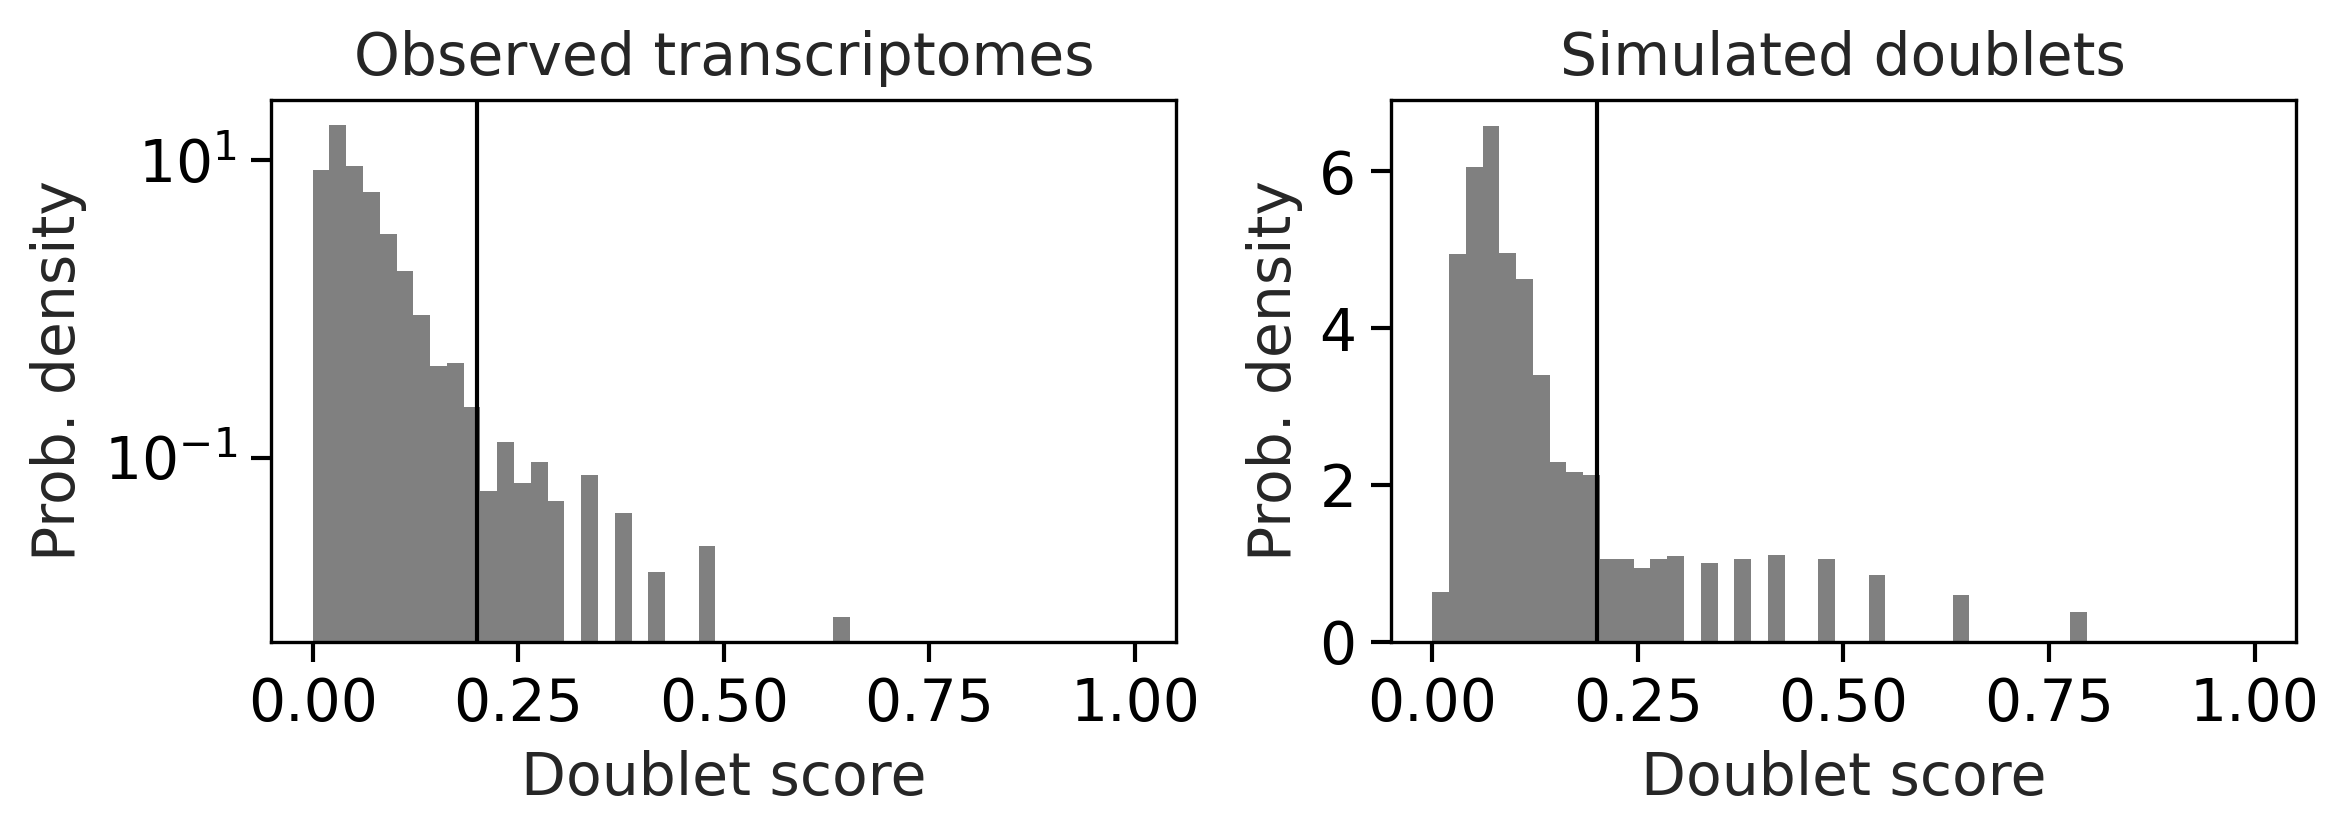

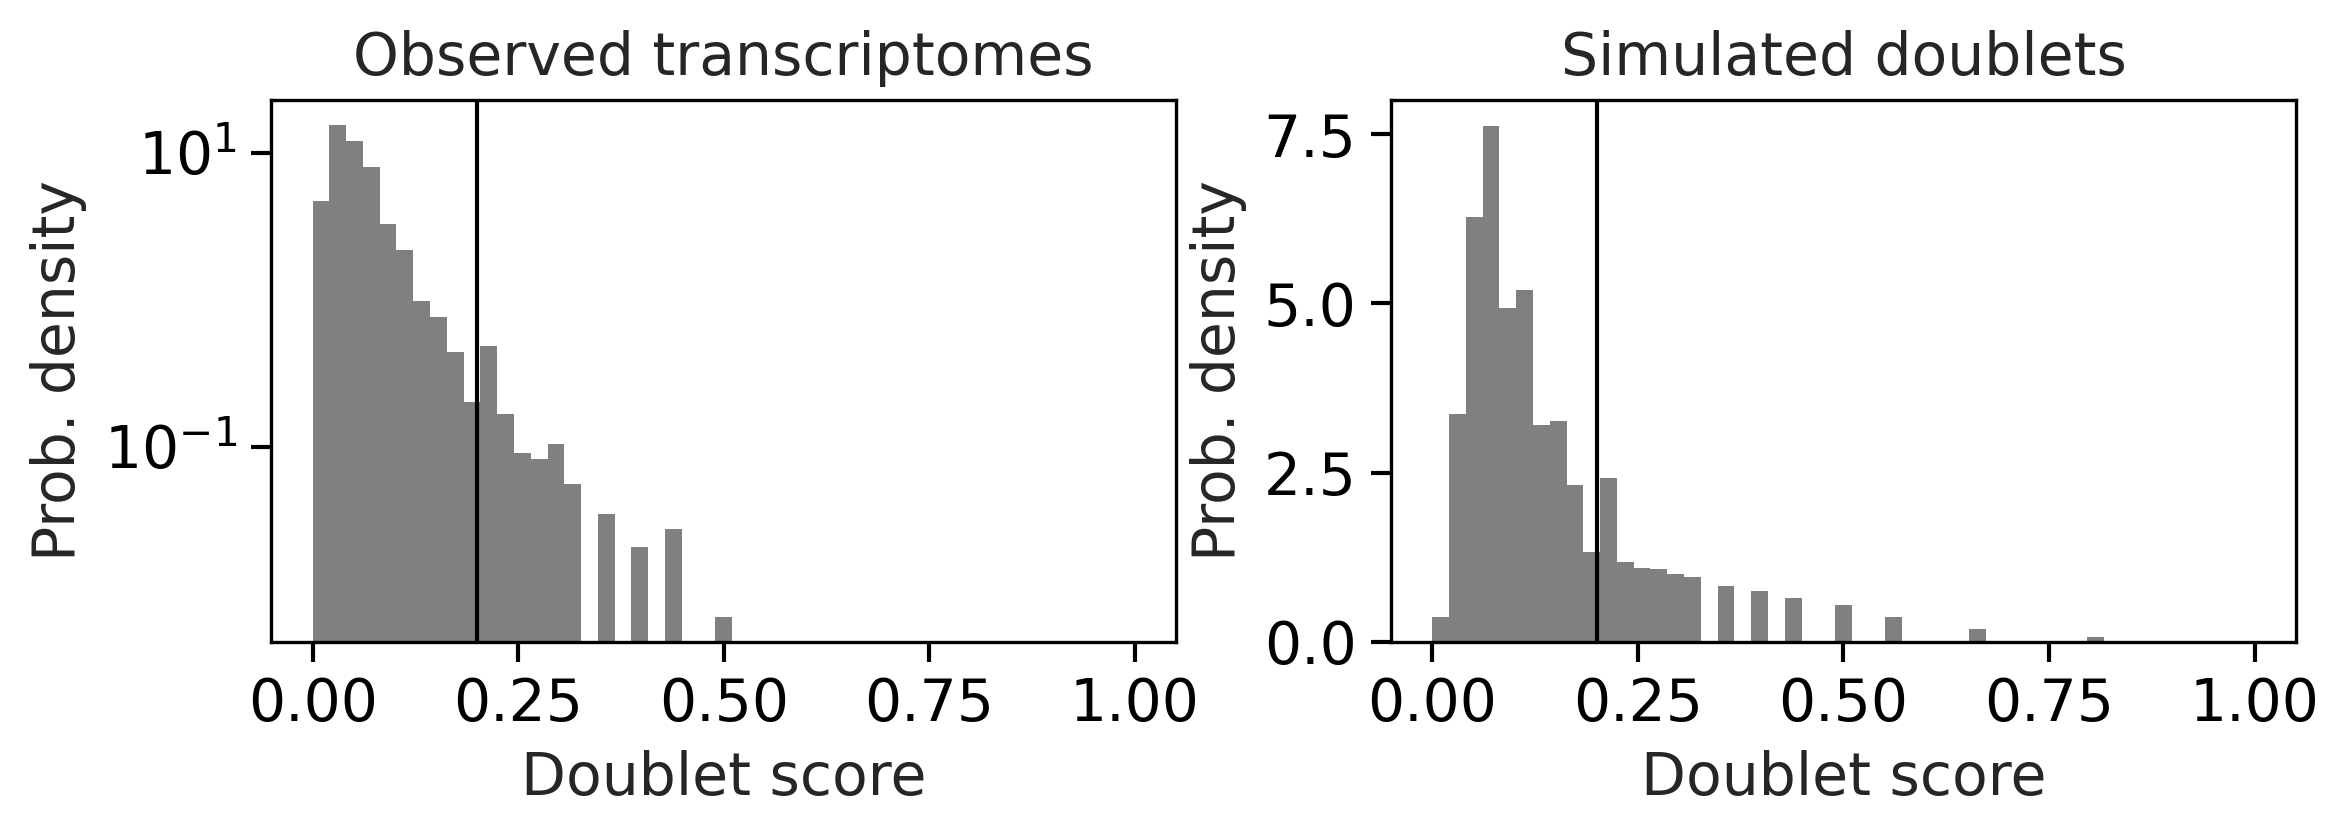

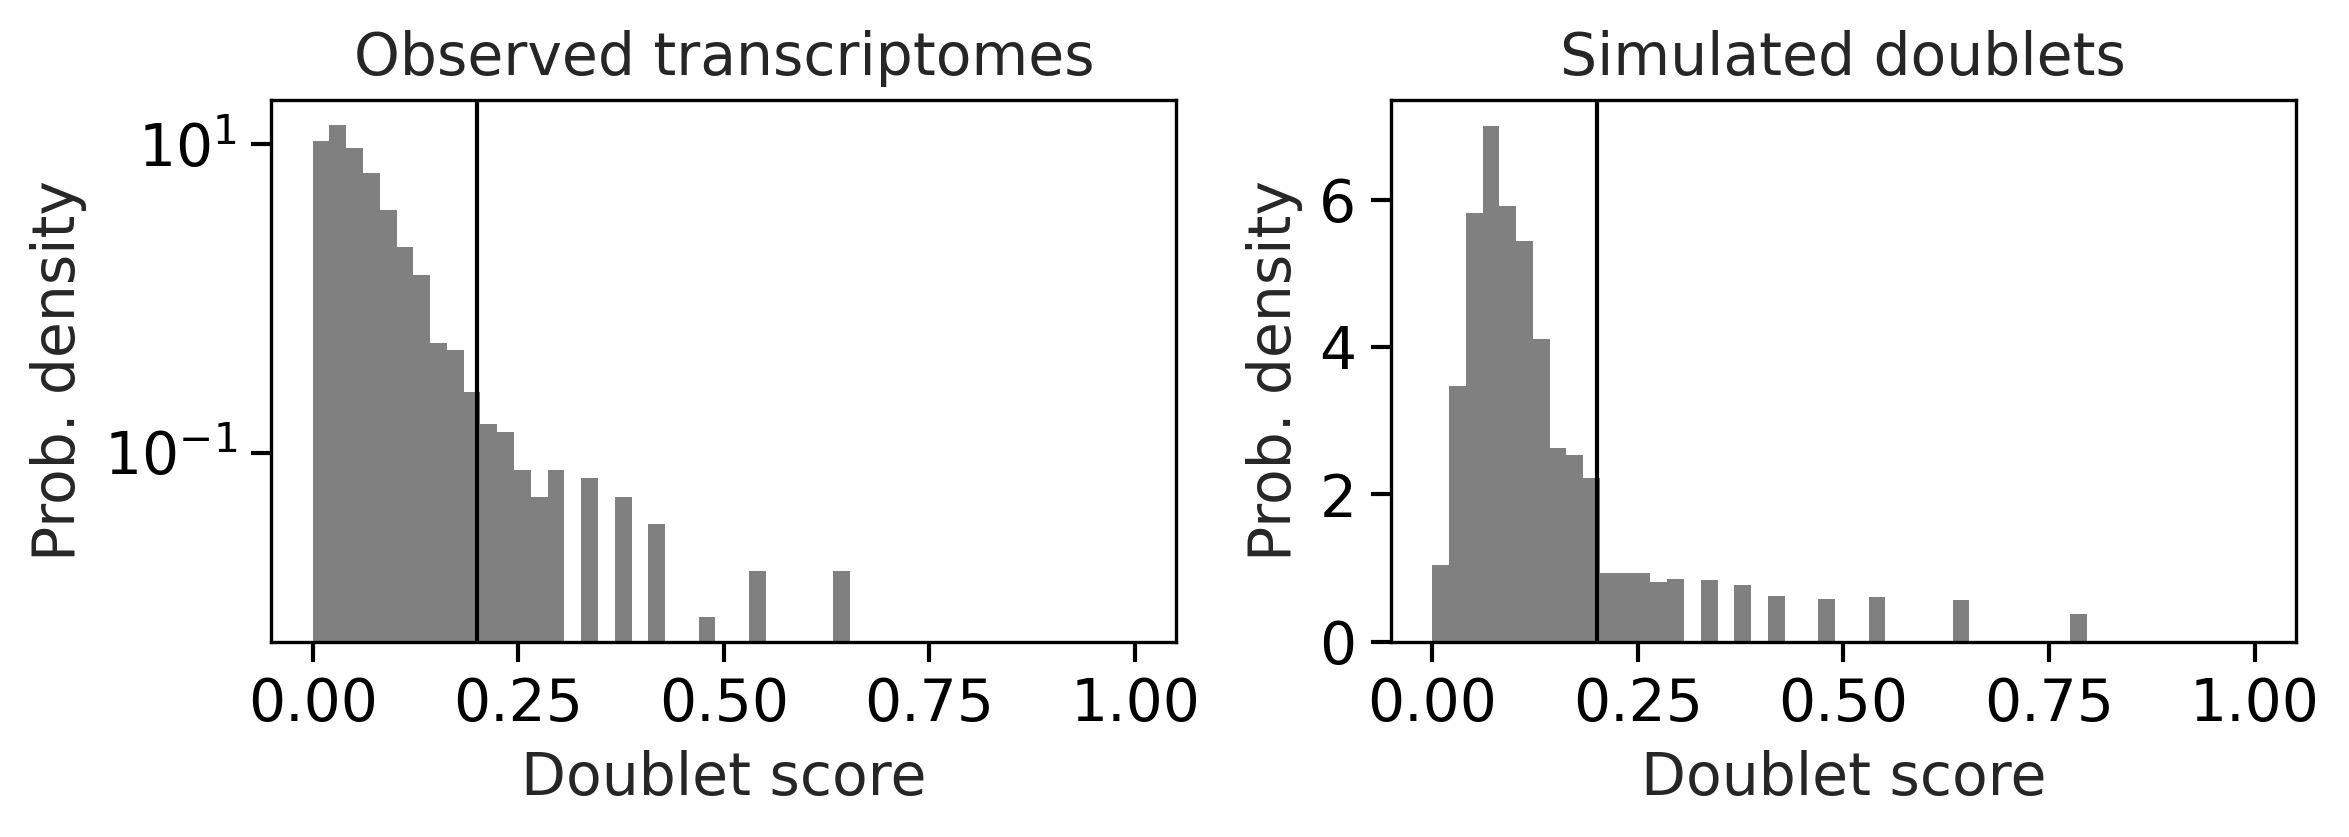

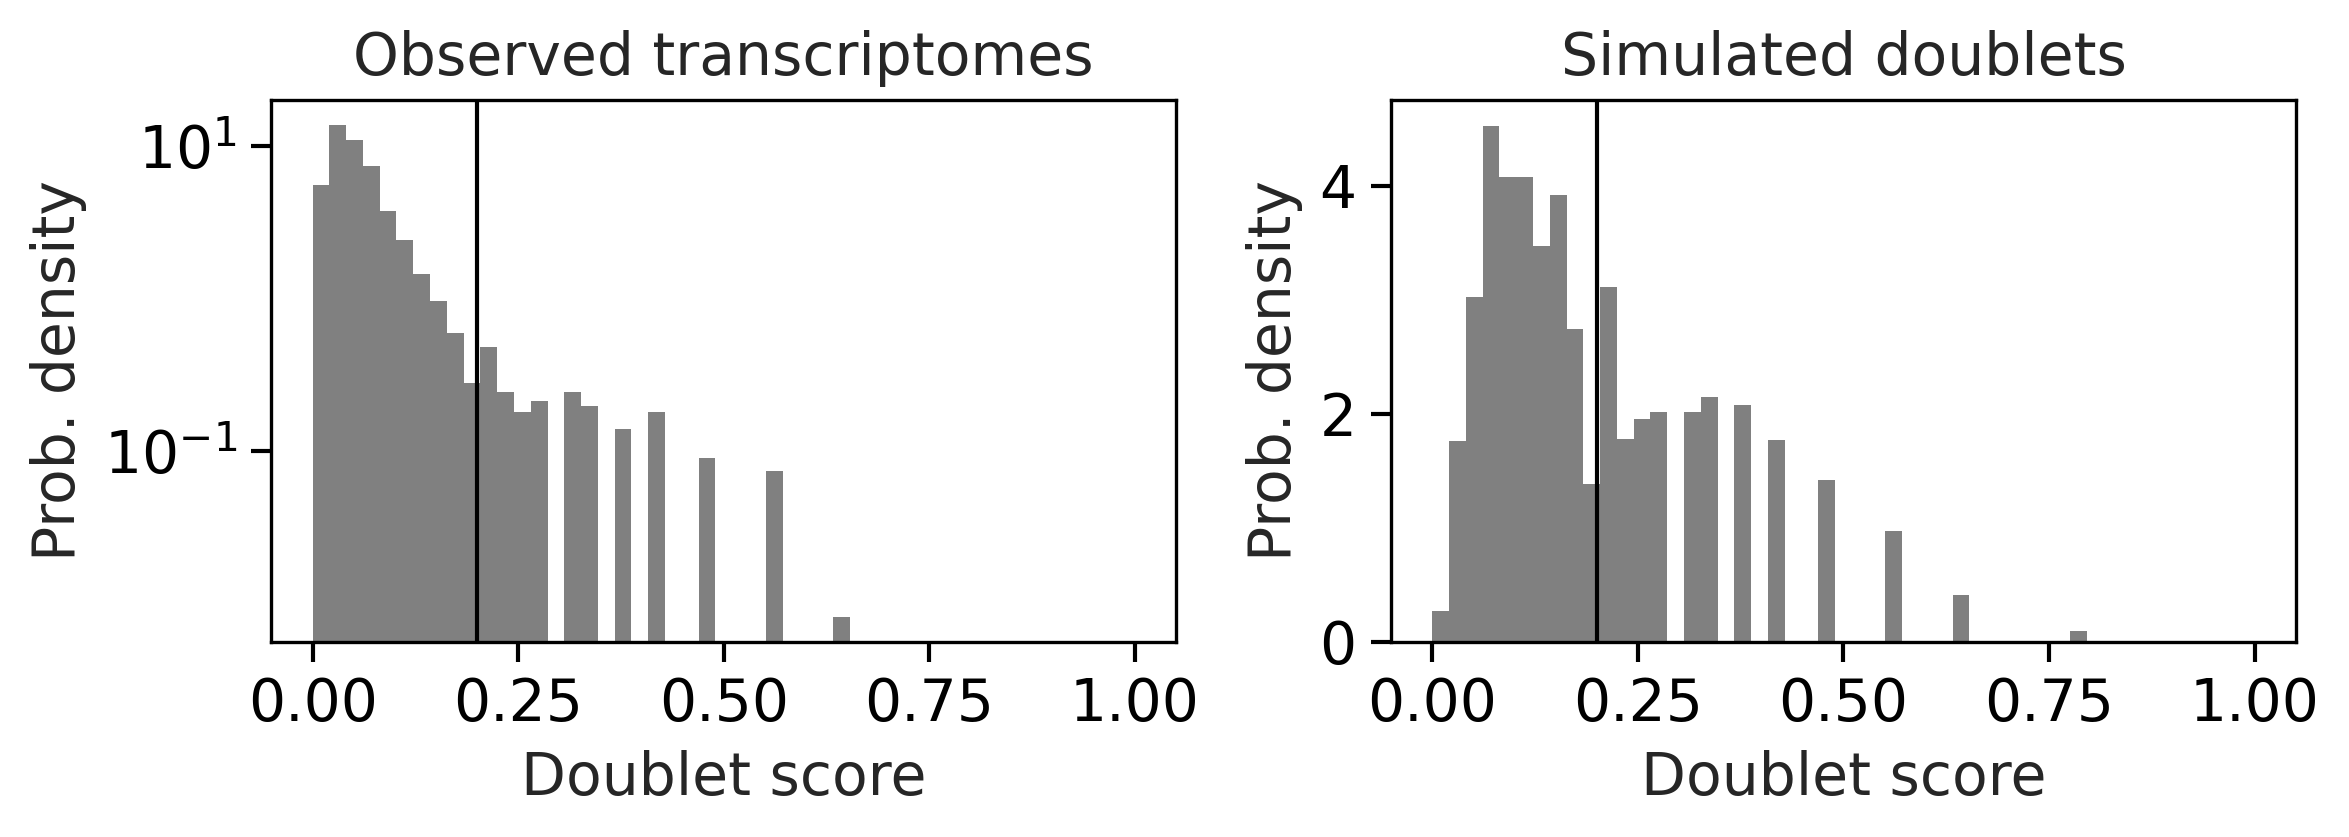

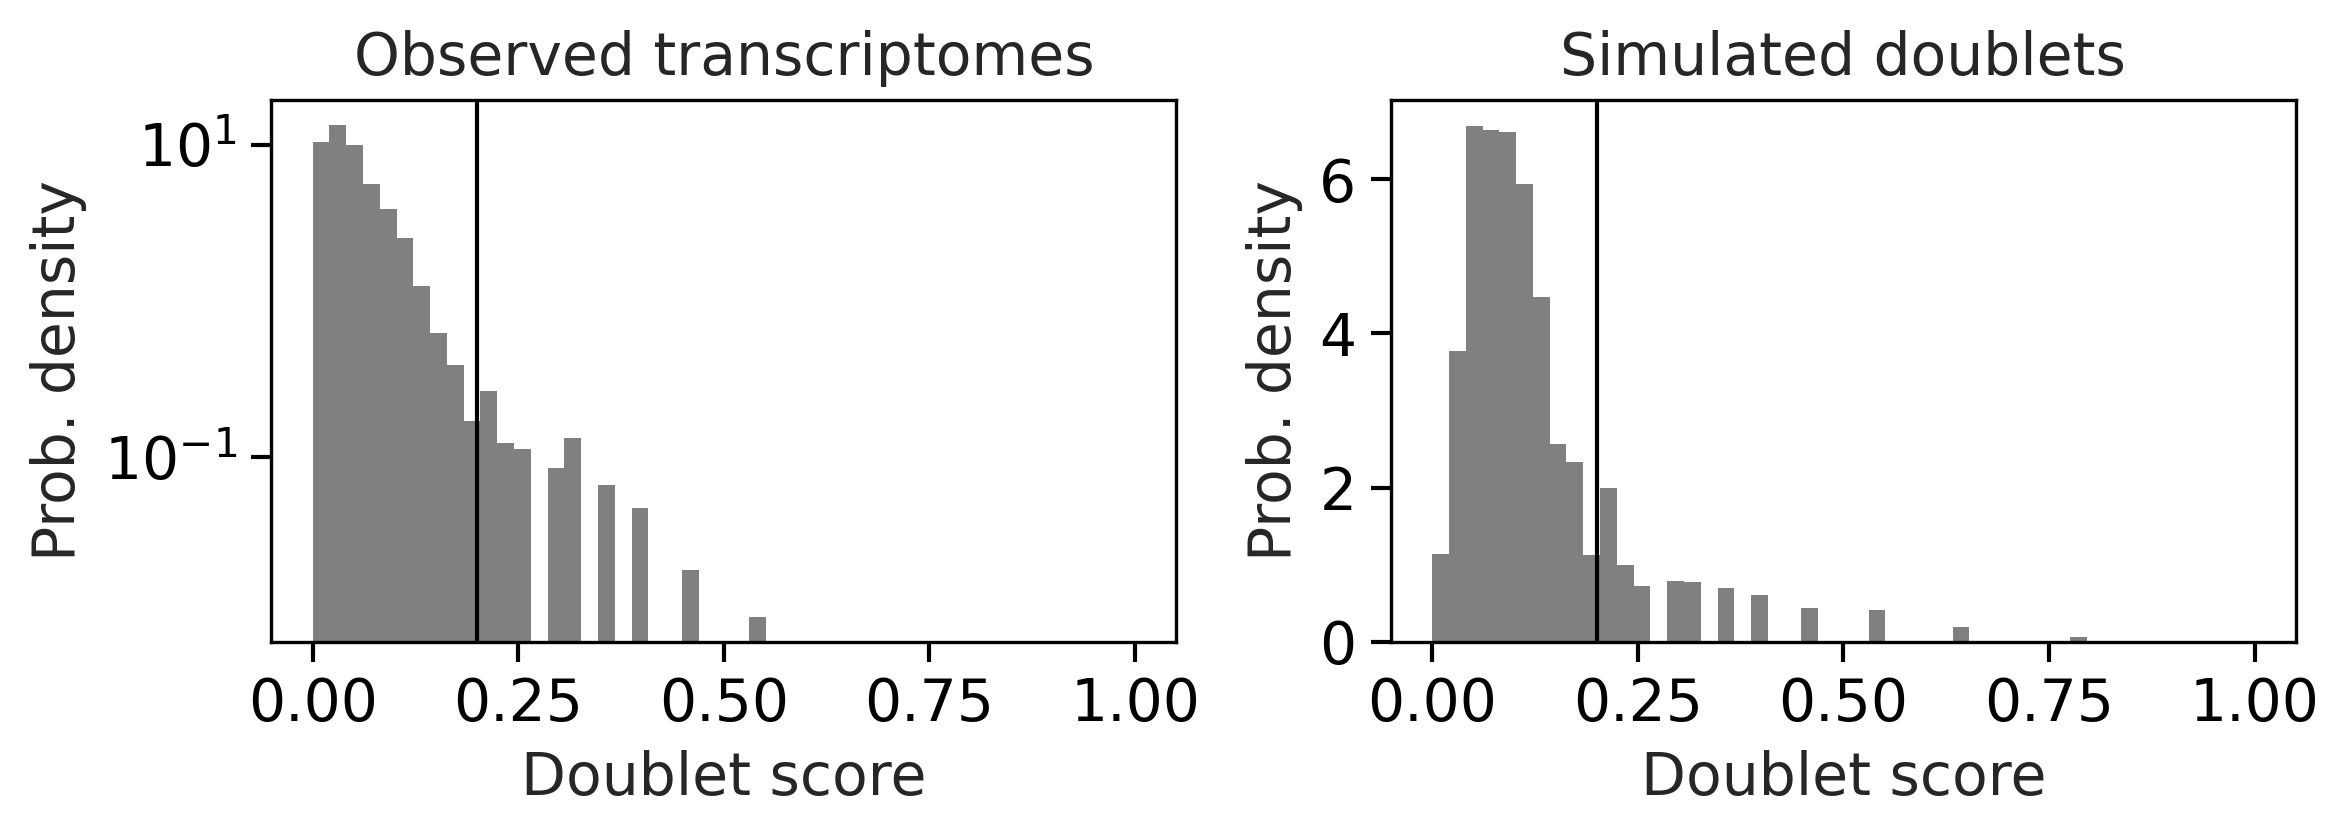

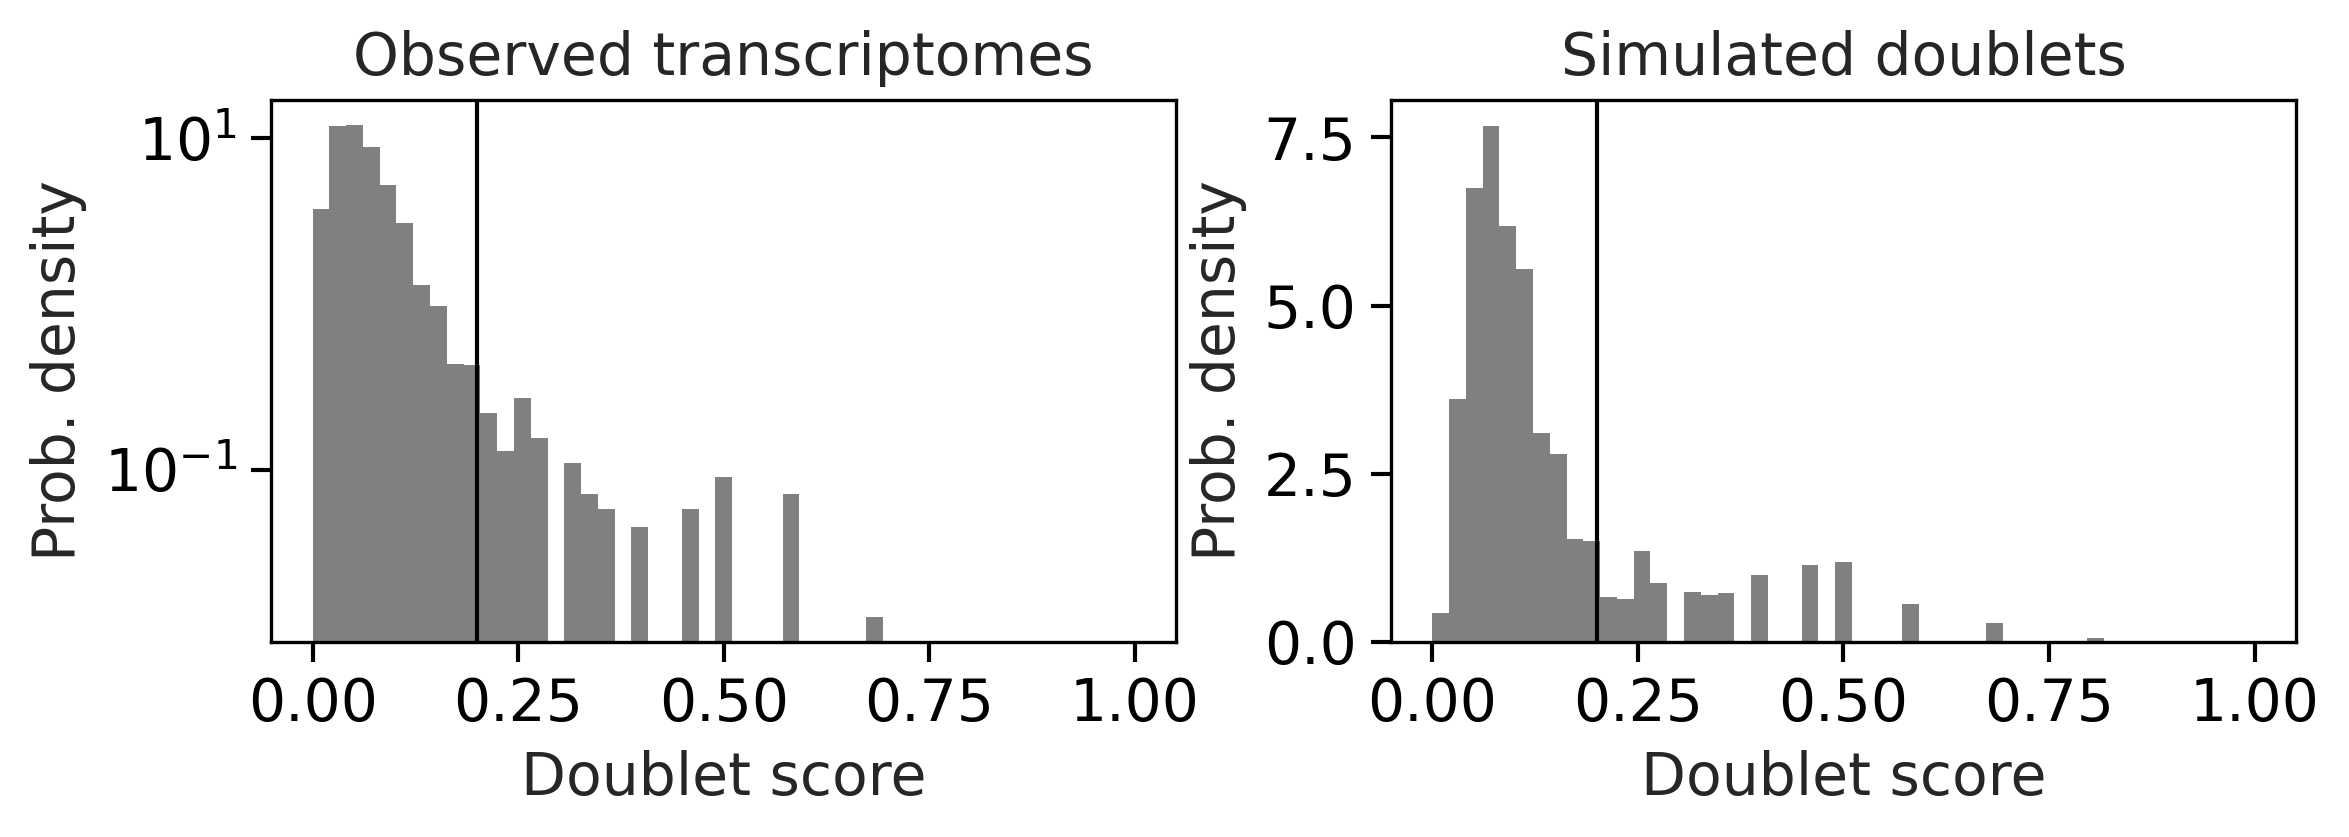

In [53]:
adata = rna.qc.scrublet(
    adata,
    doublet_threshold = 0.2, # Score threshold to use to call doublets
    batch_key = "batch", # Use batch information from a column in 'adata.obs' to run scrublet on each batch independently
    raw_counts_layer = "raw_counts" # use the raw counts data
)

In [54]:
adata

AnnData object with n_obs × n_vars = 36494 × 28124
    obs: 'batch', 'genotype', 'experiment', 'cell_type', 'scrublet_score', 'scrublet_called_doublet'
    layers: 'raw_counts'

# Preprocessing

## Get QC metrics using scanpy

In [55]:
# Annotate mito genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# Get qc metrics for each cell, gene
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)
# Basic prefiltering of empty cells, 0 counts genes
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

## Filter cells based on QC metrics

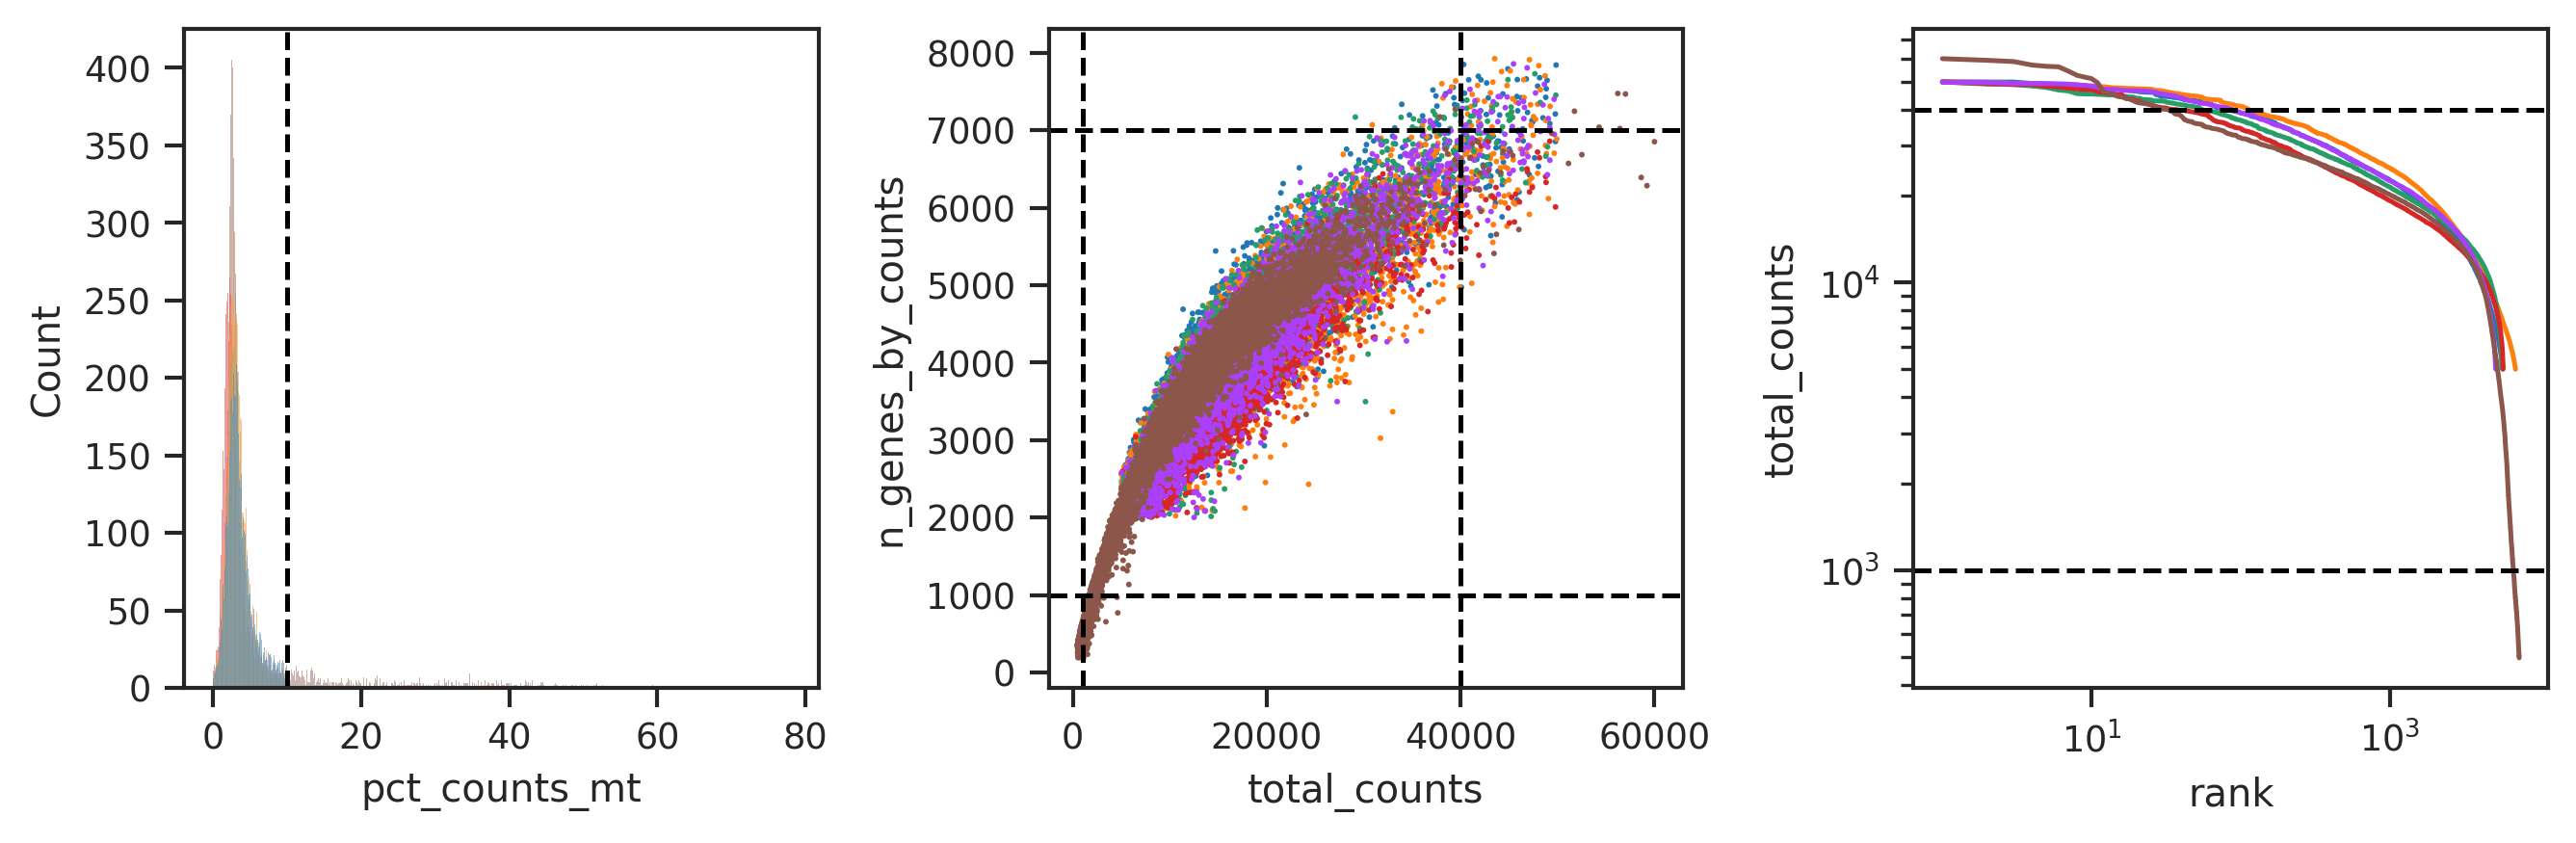

In [59]:
counts_thresholds=(1000, 40000) # The lower and upper total_counts thresholds
genes_thresholds=(1000, 7000) # The lower and upper n_genes_by_counts thresholds
mt_threshold=10 # The pct_counts_mt threshold

rna.pl.qc_plotting(
    adata,
    counts_thresholds=counts_thresholds,
    genes_thresholds=genes_thresholds,
    mt_threshold=mt_threshold,
    show_thresholds=True, # Whether to show the thresholds on the figure
    batch_key="batch", # Batch keys in adata.obs to plot seperately
    show_legend=False, # Whether to show the batch key legend
    figsize=(9, 3), 
)

2023-03-07 18:21:30 - filter_cells - INFO: Number of cells before QC filtering: 36494
2023-03-07 18:21:31 - filter_cells - INFO: Number of cells after QC filtering: 34536


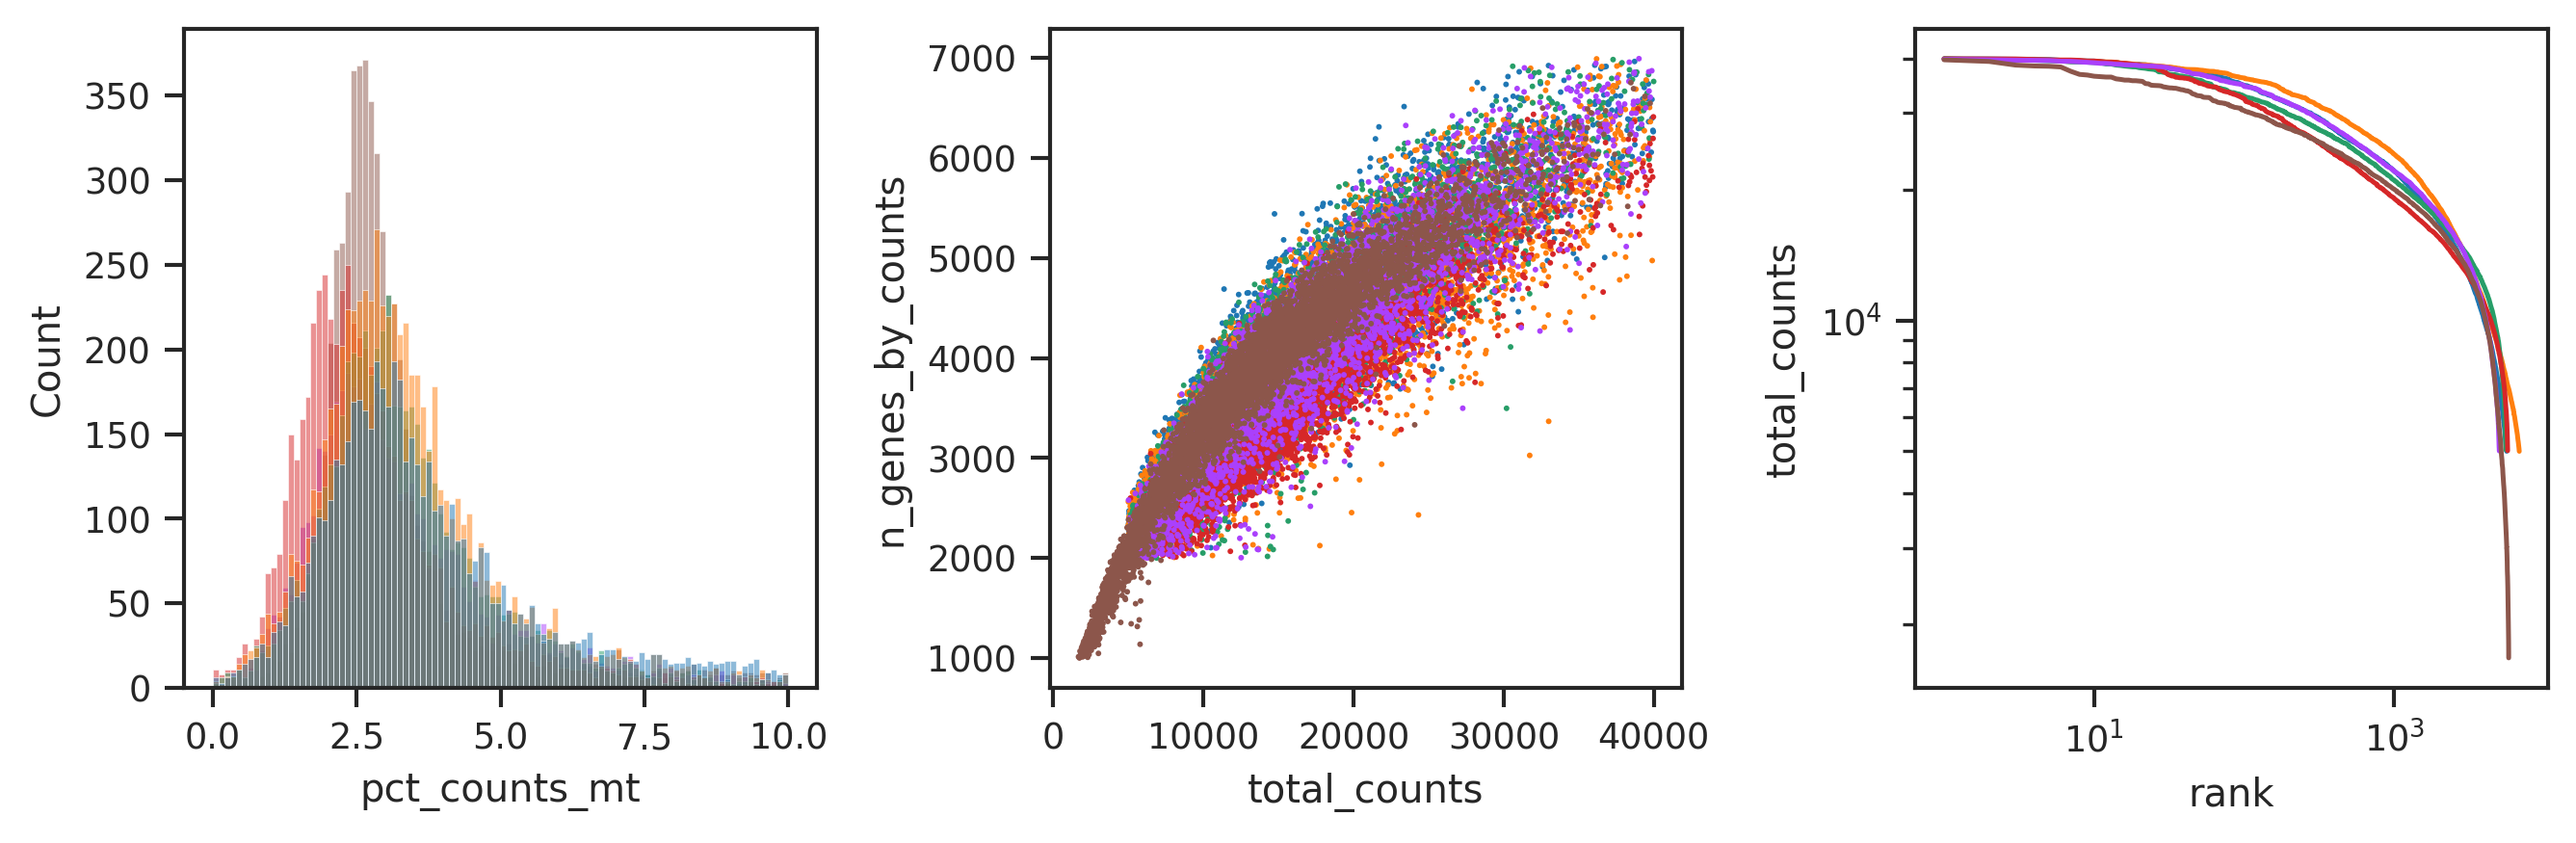

In [60]:
filteredAdata = rna.qc.filter_cells(
    adata,
    counts_thresholds=counts_thresholds, # The lower and upper total_counts thresholds
    genes_thresholds=genes_thresholds, # The lower and upper n_genes_by_counts thresholds
    mt_threshold=mt_threshold, # The pct_counts_mt threshold
)
rna.pl.qc_plotting(
    filteredAdata,
    show_thresholds=False,
    batch_key="batch",
    show_legend=False,
)

In [61]:
# Once you're happy with qc cell filtering, overwrite adata with the filtered adata
adata = filteredAdata
del filteredAdata

## Log transform data with scanpy

In [62]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # Preserve log-transformed counts in the raw attribute

## Normalize data with scanpy

This step is optional for use when downstream analysis is done within scanpy, otherwise scVI normalization can be done on its own

In [63]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
# Scanpy normalized expression is now stored in adata.X

## Normalize data with scVI

In [64]:
# Setup scVI model using raw counts and batch info
scvi.model.SCVI.setup_anndata(
    adata,
    layer="raw_counts",
    batch_key="batch",
)
model = scvi.model.SCVI(adata)

In [65]:
# Train scVI model - run on google colab with a GPU session or a Windows machine with an Nvidia GPU
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 232/232: 100%|██████████| 232/232 [08:32<00:00,  2.09s/it, loss=1.06e+04, v_num=1]

`Trainer.fit` stopped: `max_epochs=232` reached.


Epoch 232/232: 100%|██████████| 232/232 [08:32<00:00,  2.21s/it, loss=1.06e+04, v_num=1]


In [66]:
# get scVI latent space and normalized expression
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.layers["scVI_normalized"] = model.get_normalized_expression(library_size=1e4)

In [67]:
adata

AnnData object with n_obs × n_vars = 34536 × 28009
    obs: 'batch', 'genotype', 'experiment', 'cell_type', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI'
    layers: 'raw_counts', 'scVI_normalized'

# Dimensionality reduction

## UMAP

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


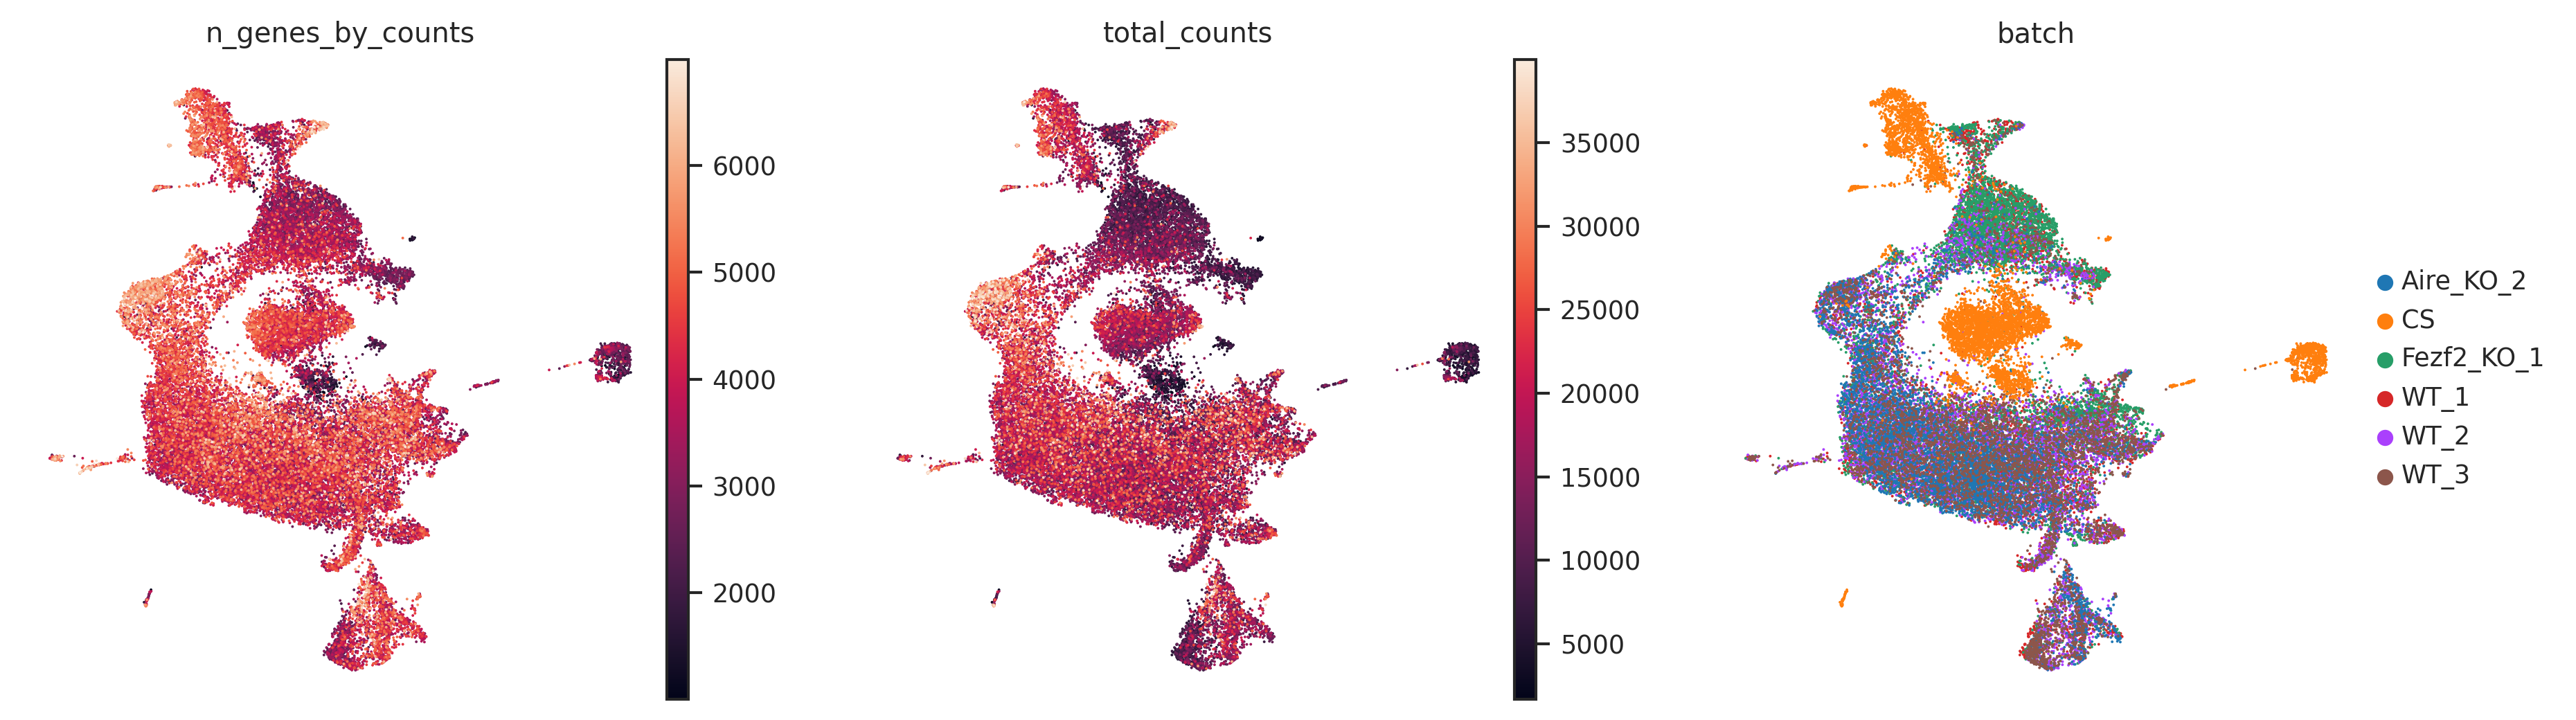

In [70]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)
# Check dimensionality reduction (look for batch effects here if applicable)
sc.pl.umap(
    adata,
    color=["n_genes_by_counts", "total_counts", "batch"],
)

/conda-global-envs/single-cell-analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


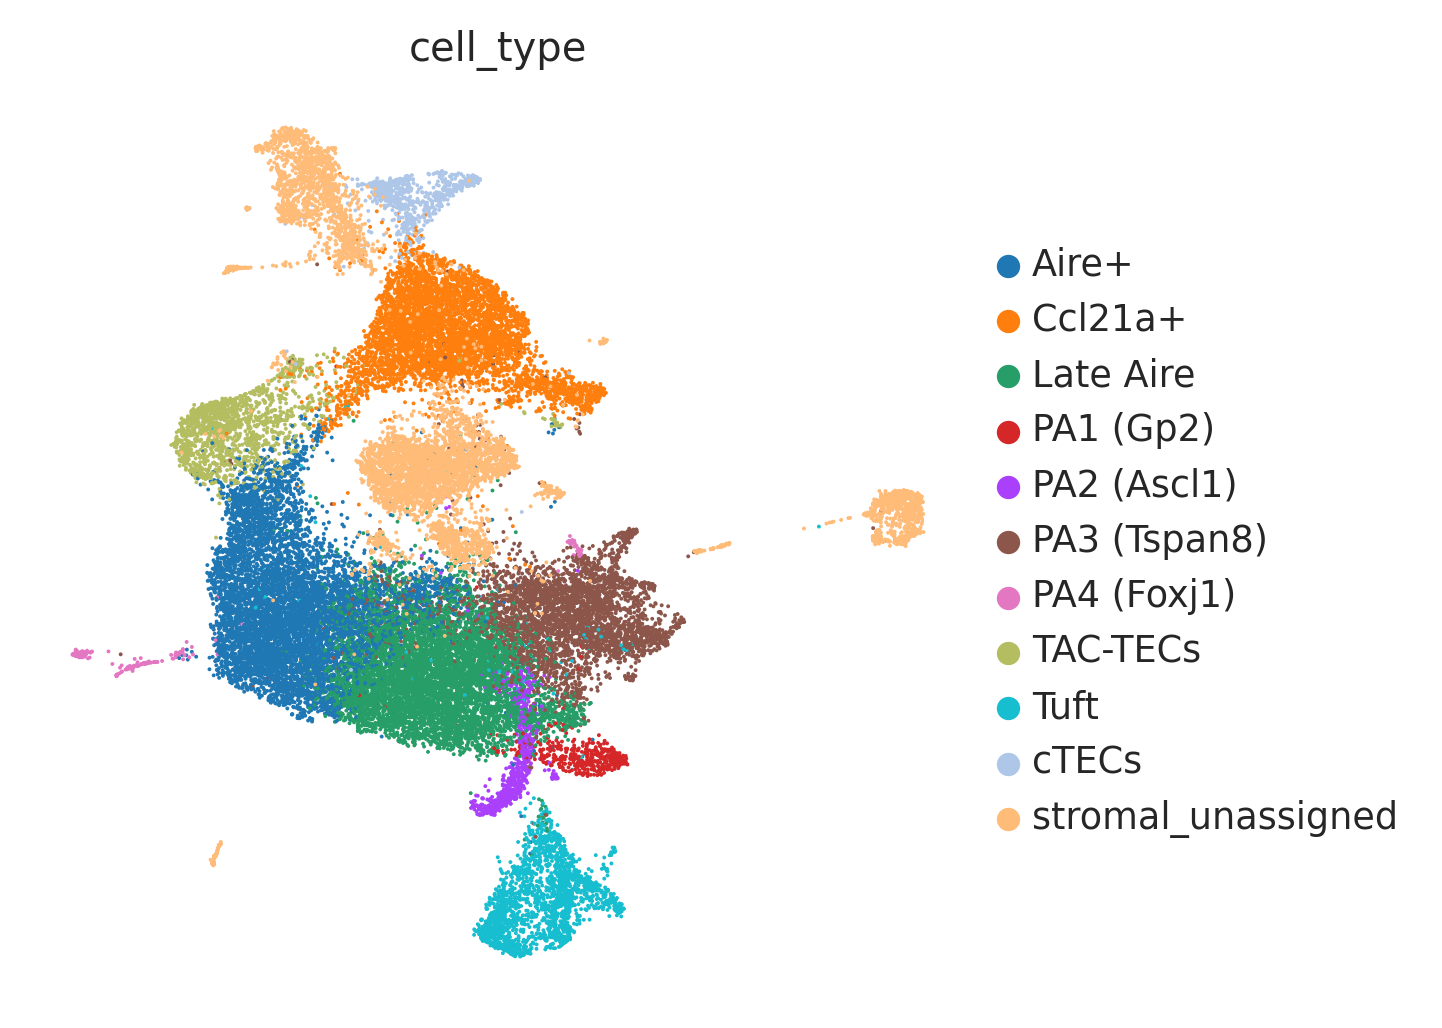

In [69]:
sc.pl.umap(
    adata,
    color=["cell_type"],
)

In [71]:
import scrnatools as rna

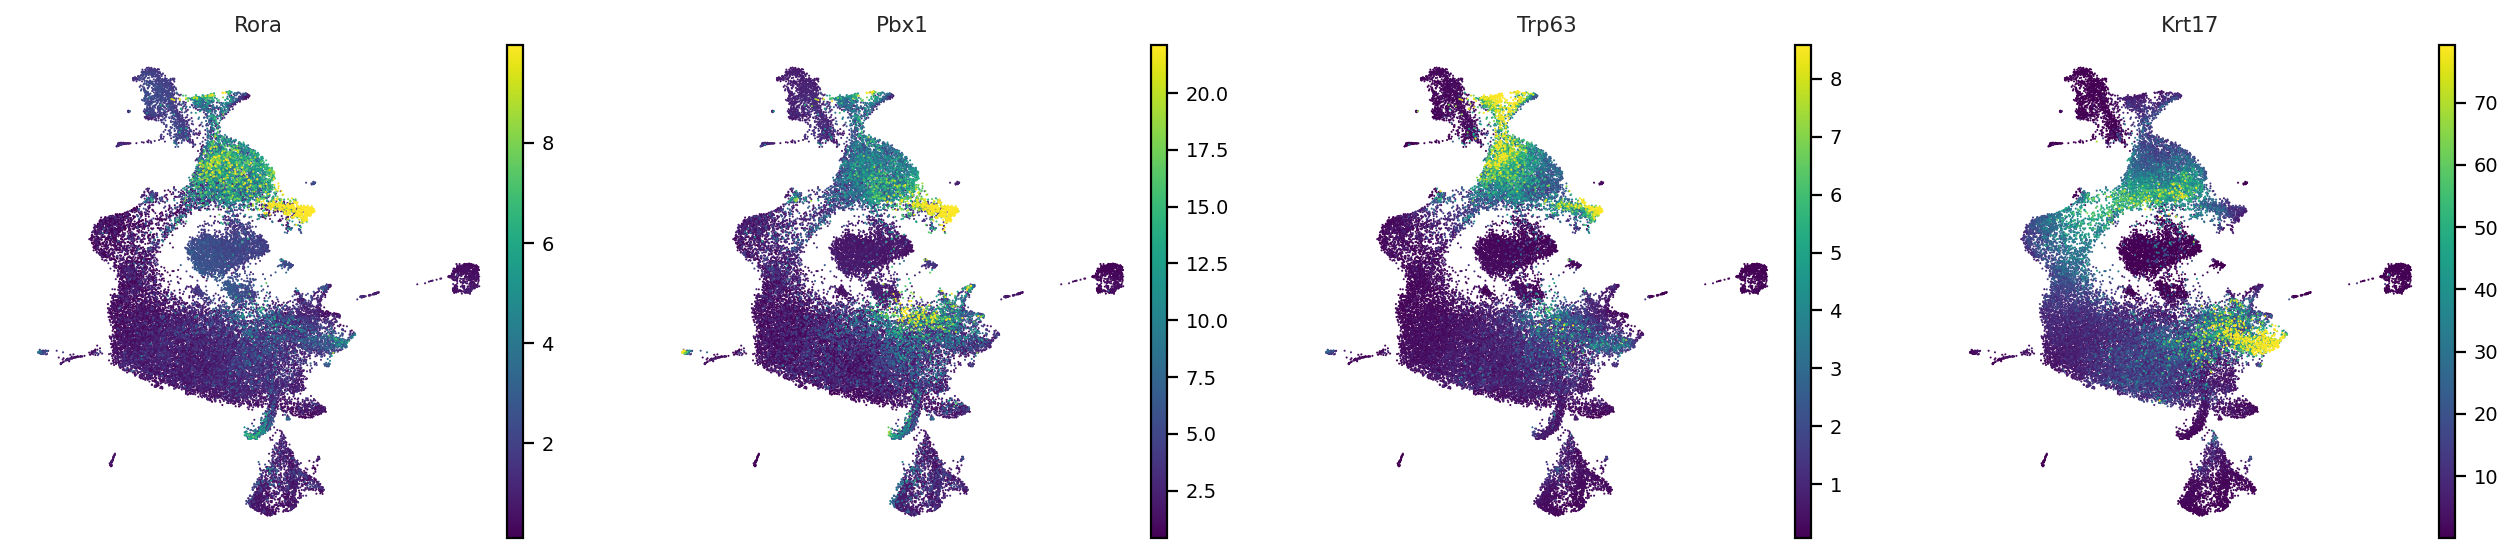

In [73]:
rna.pl.gene_embedding(
    adata,
    gene_list = ["Rora", "Pbx1", "Trp63", "Krt17"],
    layer="scVI_normalized",
    cmap="viridis",
)